## Hotel Reviews Analysis

In [1]:
import json
import pandas as pd
from collections import defaultdict
import csv
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta

## **1. Dataset Overview**

**Load the Data**

'JSON.load()' is the appropriate way to load nested data into Python.

In [2]:
with open("hotel_data.json", mode = "r", encoding = "utf-8") as f:
    data = json.load(f)

**Overall Data Structure**

The top level structure of the data is a list of dicts with each dict representing a different hotel. At this level we get basic information about the hotels such as their names, their ranking on tripadvisor and the total number of reviews they've received, all in string format, along with their overall ratings as a float. Nested within each higher level hotel dict is another list of dicts containing information about the individual reviews. There are exactly 35 reviews in the dataset for each hotel, as shown in the code below. This level of the data contains the text of the reviews themselves along with their responses (both strings) and other metrics such as the rating given, the date of stay etc. Within this level there is a further sub dictionary containing more specific ratings data relating to the location, cleanliness and service. Moving back to the level of the hotel dicts each also includes a number of sub dictionaries containing metadata about the web scraping. For the most part the meta data is not informative regarding the hotels and the reviews except for one column, META.ADDED which is saved for a later analysis. 

**Discerning the total number of reviews**

We first loop over the hotel data and append the number of reviews per hotel to a list to gauge the size of the dataset.

In [3]:
Reviews = []
# Loop over all hotels and append the length of the dicts in the 'reviews' list of dicts to a list which is then summed giving
# the total number of reviews.
for hotel in data:
    Reviews.append(len(hotel["reviews"]))

# There are exactly the same amount of reviews per hotel, 35. 
print(Reviews)

[35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35]


In [4]:
sum(Reviews) # Total number of reviews. 

1085

**Key Value Pairs in Relation to Total Reviews**

Next we loop over the key value pairs on the inner 'reviews' level and store them in a default dict. The data isn't perfectly neat. While all reviews contain mostly the same information, a sizeable proportion of them do not have the 'date_of_stay', 'travel_company', 'response_date' or 'responder' variables as shown in the following code.

In [5]:
# Create a default dict because a regular dict will throw and error if there are missing keys in a review entry. 
KV_Frequency = defaultdict(int)

for hotel in data:
    for reviews in hotel["reviews"]:
        for k, v in reviews.items():
# This line creates the key in the default dict for the keys first occurence then adds a 1 to the value for each occurence. 
            KV_Frequency[k] += 1   
    
KV_Frequency

defaultdict(int,
            {'date': 1085,
             'mobile': 1085,
             'rating': 1085,
             'response': 1085,
             'headline': 1085,
             'review': 1085,
             'date_of_stay': 475,
             'travel_company': 475,
             'response_date': 334,
             'responder': 334,
             'username': 1085,
             'location': 1085,
             'votes': 1085,
             'contributions': 1085,
             'images': 1085,
             'specific_ratings': 1085,
             'partnership': 1085})

**Lower Level Review Data**

Looping over the third level dict relating to specific ratings also paints a messy picture. This information is present intermittently for a subsection of the overall reviews and hotels. 

In [6]:
KV_Frequency2 = defaultdict(int)

for hotel in data:
    for reviews in hotel["reviews"]:
        for k, v in reviews["specific_ratings"].items():
            KV_Frequency2[k] += 1  
            
KV_Frequency2

defaultdict(int,
            {'Location': 214,
             'Cleanliness': 208,
             'Service': 472,
             'Sleep Quality': 211,
             'Rooms': 228,
             'Value': 210})

**Hotel Level Data**

The higher level hotel data is tidier. With 30 hotels overall there is no missing data in the key value pairs for any of them.

In [7]:
len(data) # Total number of hotels.

31

In [8]:
H_Frequency = defaultdict(int)

for hotel in data:
        for k in hotel:
            H_Frequency[k] += 1           

H_Frequency

defaultdict(int,
            {'name': 31,
             'link': 31,
             'reviewquantity': 31,
             'reviews': 31,
             'ranking': 31,
             'overall_rating': 31,
             'doctype': 31,
             'META': 31})

## **2. Cleaning**

**Convert Data to DataFrame**

The nesting of a list of dicts inside another list of dicts means that the 'json_normalize' function is not sufficient to normalize the data. Given that 'json_normalize' works fine on the outer layer hotels list of dicts, the approach chosen here is to pull the review data into a separate list of dicts, normalize both into a Data Frame separately, and then join the data together on a common variable 'name' which is added  to the review data.

In [9]:
for hotel in data:
    for r in hotel["reviews"]:
        r["name"] = hotel["name"] # I add a key value pair to each review corresponding to the hotel that review relates to. 
                                  # This allows easy joining of the review and hotel data later. 

In [10]:
Hotels = pd.json_normalize(data)
Hotels

,name,link,reviewquantity,reviews,ranking,overall_rating,doctype,META.ADDED,META.name.ADDED_AT,META.name.ADDED_USING,...,META.overall_rating.ADDED_METHOD,META.overall_rating.FUNCTION_VERSION,META.overall_rating.FUNCTION_VERSION_DATE,META.overall_rating.FUNCTION_TYPE,META.doctype.ADDED_AT,META.doctype.ADDED_USING,META.doctype.ADDED_METHOD,META.doctype.FUNCTION_VERSION,META.doctype.FUNCTION_VERSION_DATE,META.doctype.FUNCTION_TYPE
0,Crowne Plaza Amsterdam South,http://www.tripadvisor.com/Hotel_Review-g18859...,"1,293 reviews","[{'date': 'February 24, 2018', 'mobile': False...",#23 of 376 Hotels in Amsterdam,4.5,tripadvisor_hotel,2018-03-02T14:06:02.077515,2018-03-02T14:06:02.077488,tripadvisor,...,Fetches reviews from Tripadvisor.com,.1,2018-01-24T00:00:00,scraper,2018-03-02T14:06:02.077488,tripadvisor,Fetches reviews from Tripadvisor.com,.1,2018-01-24T00:00:00,scraper
1,Hotel The Neighbour's Magnolia,http://www.tripadvisor.com/Hotel_Review-g18859...,891 reviews,"[{'date': 'February 26, 2018', 'mobile': True,...",#133 of 376 Hotels in Amsterdam,4.5,tripadvisor_hotel,2018-03-02T14:10:58.055929,2018-03-02T14:10:58.055893,tripadvisor,...,Fetches reviews from Tripadvisor.com,.1,2018-01-24T00:00:00,scraper,2018-03-02T14:10:58.055893,tripadvisor,Fetches reviews from Tripadvisor.com,.1,2018-01-24T00:00:00,scraper
2,Park Hotel Amsterdam,http://www.tripadvisor.com/Hotel_Review-g18859...,"2,821 reviews","[{'date': 'February 24, 2018', 'mobile': True,...",#92 of 376 Hotels in Amsterdam,4.0,tripadvisor_hotel,2018-03-02T14:08:24.764043,2018-03-02T14:08:24.764013,tripadvisor,...,Fetches reviews from Tripadvisor.com,.1,2018-01-24T00:00:00,scraper,2018-03-02T14:08:24.764013,tripadvisor,Fetches reviews from Tripadvisor.com,.1,2018-01-24T00:00:00,scraper
3,Hotel Alexander,http://www.tripadvisor.com/Hotel_Review-g18859...,582 reviews,"[{'date': 'February 23, 2018', 'mobile': True,...",#151 of 376 Hotels in Amsterdam,4.0,tripadvisor_hotel,2018-03-02T14:19:18.505093,2018-03-02T14:19:18.505060,tripadvisor,...,Fetches reviews from Tripadvisor.com,.1,2018-01-24T00:00:00,scraper,2018-03-02T14:19:18.505060,tripadvisor,Fetches reviews from Tripadvisor.com,.1,2018-01-24T00:00:00,scraper
4,Nova Hotel Amsterdam,http://www.tripadvisor.com/Hotel_Review-g18859...,"1,084 reviews","[{'date': 'February 24, 2018', 'mobile': True,...",#119 of 376 Hotels in Amsterdam,4.0,tripadvisor_hotel,2018-03-02T14:22:29.145286,2018-03-02T14:22:29.145259,tripadvisor,...,Fetches reviews from Tripadvisor.com,.1,2018-01-24T00:00:00,scraper,2018-03-02T14:22:29.145259,tripadvisor,Fetches reviews from Tripadvisor.com,.1,2018-01-24T00:00:00,scraper
5,Hotel Atlas Vondelpark,http://www.tripadvisor.com/Hotel_Review-g18859...,198 reviews,"[{'date': 'February 13, 2018', 'mobile': True,...",#223 of 376 Hotels in Amsterdam,3.5,tripadvisor_hotel,2018-03-02T14:15:09.496345,2018-03-02T14:15:09.496312,tripadvisor,...,Fetches reviews from Tripadvisor.com,.1,2018-01-24T00:00:00,scraper,2018-03-02T14:15:09.496312,tripadvisor,Fetches reviews from Tripadvisor.com,.1,2018-01-24T00:00:00,scraper
6,Hotel CC,http://www.tripadvisor.com/Hotel_Review-g18859...,"1,392 reviews","[{'date': 'February 28, 2018', 'mobile': True,...",#147 of 376 Hotels in Amsterdam,4.0,tripadvisor_hotel,2018-03-02T14:25:56.748130,2018-03-02T14:25:56.748098,tripadvisor,...,Fetches reviews from Tripadvisor.com,.1,2018-01-24T00:00:00,scraper,2018-03-02T14:25:56.748098,tripadvisor,Fetches reviews from Tripadvisor.com,.1,2018-01-24T00:00:00,scraper
7,XO Hotels Blue Tower,http://www.tripadvisor.com/Hotel_Review-g18859...,"1,912 reviews","[{'date': 'February 28, 2018', 'mobile': False...",#182 of 376 Hotels in Amsterdam,3.5,tripadvisor_hotel,2018-03-02T14:28:27.271504,2018-03-02T14:28:27.271475,tripadvisor,...,Fetches reviews from Tripadvisor.com,.1,2018-01-24T00:00:00,scraper,2018-03-02T14:28:27.271475,tripadvisor,Fetches reviews from Tripadvisor.com,.1,2018-01-24T00:00:00,scraper
8,Hotel Nadia,http://www.tripadvisor.com/Hotel_Review-g1885

In [11]:
Reviews = []

# Looping over the reviews level data and appending it to a list.
for hotel in data:
    for r in hotel["reviews"]:
        Reviews.append(r)

Reviews_DF = pd.json_normalize(Reviews)

# All data about reviews is saved to a csv file which can be opened in excel and easily understood by less tech savvy clients. 
Reviews_DF.to_csv("Reviews.csv", sep = ",")

Reviews_DF

,date,mobile,rating,response,headline,review,date_of_stay,travel_company,response_date,responder,...,contributions,images,partnership,name,specific_ratings.Location,specific_ratings.Cleanliness,specific_ratings.Service,specific_ratings.Sleep Quality,specific_ratings.Rooms,specific_ratings.Value
0,"February 24, 2018",False,5,Thank you so much for sharing your experience ...,comfort plus,picked for vicinity to airport and transport l...,February 2018,traveled with family,Responded 5 days ago,"CPSouth, Guest Relations Manager at Crowne Pla...",...,8.0,[],False,Crowne Plaza Amsterdam South,40,50,40,NaN,NaN,NaN
1,"February 18, 2018",True,5,"Dear valued guest, dear teegeegeegee,It is won...",Amazing service,I stayed at this hotel for 5 nights for a cour...,NaN,NaN,Responded 1 week ago,"CPSouth, Guest Relations Manager at Crowne Pla...",...,46.0,[],False,Crowne Plaza Amsterdam South,NaN,NaN,NaN,NaN,NaN,NaN
2,"February 11, 2018",False,4,"Dear Krzysztof,Thank you very much for your ex...",Business hotel in South of Amsterdam,This is one of those hotels without much of ch...,February 2018,traveled on business,Responded 2 weeks ago,"CPSouth, Guest Relations Manager at Crowne Pla...",...,34.0,[],False,Crowne Plaza Amsterdam South,NaN,50,40,50,NaN,NaN
3,"February 8, 2018",False,5,Thanks a million for this wonderful 5 out of 5...,Excellent hotel in Amsterdam South business di...,The Crowne Plaza is a very comfortable hotel w...,December 2017,traveled with family,Responded 2 weeks ago,"CPSouth, Guest Relations Manager at Crowne Pla...",...,62.0,[],False,Crowne Plaza Amsterdam South,NaN,50,50,50,NaN,NaN
4,"February 6, 2018",True,5,"Dear valued guest, Thank you for sharing your ...",Great place to say!,"Nicely appointed rooms, clean and fresh. Great...",NaN,NaN,Responded 3 weeks ago,"CPSouth, General Manager at Crowne Plaza Amste...",...,47.0,[],False,Crowne Plaza Amsterdam South,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080,"May 5, 2017",True,5,"Dear Skinsk8,THank you for your very nice revi...",Lovely quiet location,This lovely hotel is in a quiet neighborhood o...,NaN,NaN,"Responded May 18, 2017","Rietje_Lachchi, Operations Manager at Best Wes...",...,17.0,[],False,Best Western Delphi Hotel,NaN,NaN,NaN,NaN,NaN,NaN
1081,"May 2, 2017",False,4,NA,Outside the centre but good transport links,A small hotel near the No. 5 tram (easy to get...,May 2017,traveled with friends,NaN,NaN,...,36.0,[],True,Best Western Delphi Hotel,40,30,50,40,40,40
1082,"April 12, 2017",False,1,"Dear Rogern577,Thank you for leaving a review ...",Not sure how award for star is made,"for me this was a terrible hotel, very expensi...",March 2017,traveled on business,"Responded April 18, 2017","Rietje_Lachchi, Operations Manager at Best Wes...",...,49.0,[],False,Best Western Delphi Hotel,NaN,NaN,20,10,NaN,10
1083,"April 4, 2017",False,2,"Dear Dieter,Thank you for leaving a review reg...",Small Western and not Best Western,I booked the room lately for me and my wife. A...,April 2017,traveled with family,"Responded April 10, 2017","Rietje_Lachchi, Operations Manager at Best Wes...",...,9.0,[],False,Best Western Delphi Hotel,30,NaN,30,NaN,NaN,20


**Review Text Stored in CSV Simply**

This code stores just the text of the reviews and no other information in a csv file which can be given to a less tech savvy client and read simply in a text editor. 

In [12]:
Reviews_Text = []

for r in Reviews:
    for k, v in r.items():
        if k == "review": # Selecting only the review text data. 
            Reviews_Text.append(v)
            
Reviews_Text

with open('Reviews_Text.csv', mode='w', encoding = "utf-8") as rt:
    for review in Reviews_Text:
        rt.write(review)
        rt.write("\n\n") # For ease of reading an extra space is added to the data. 

### **2.1 Cleaning the Reviews Dataset**

**Drop columns not involved in analysis**

The first cleaning step is to create a new data frame just containing the variables needed for the statistical analyses and visualizations. 

In [13]:
Reviews_Analysis = Reviews_DF.drop(columns = ["headline", "images", "location", "contributions", "responder", "username"])

**Datatypes in the reviews dataset**

A quick glance at the reduced dataset data types flags some objectives for cleaning. The 'date' variable for example needs to be parsed to a datetime object as should the specific ratings variables be parsed to int. 

In [14]:
Reviews_Analysis.dtypes

date                               object
mobile                               bool
rating                              int64
response                           object
review                             object
date_of_stay                       object
travel_company                     object
response_date                      object
votes                             float64
partnership                          bool
name                               object
specific_ratings.Location          object
specific_ratings.Cleanliness       object
specific_ratings.Service           object
specific_ratings.Sleep Quality     object
specific_ratings.Rooms             object
specific_ratings.Value             object
dtype: object

**Parse the Date**

In [15]:
Reviews_Analysis["date"] = pd.to_datetime(Reviews_Analysis["date"]) # The variable is changed to type 'datetime'. 

**Rename Columns and Categories**

The 'travel_company' variables' categories are simplified for sake of space in the visualizations.

In [16]:
valuemap = {"traveled with family" : "family", "traveled on business" : "business", "traveled as a couple" : "couple", 
            "traveled with friends" : "friends", "traveled solo" : "solo", "nan" : "nan"}

Reviews_Analysis["travel_company"] = Reviews_Analysis["travel_company"].replace(valuemap)

Simplify the names of the specific ratings columns.

In [17]:
# A list comprehension with regex is used to split the column names at the '.' and retain only the latter half. 
Reviews_Analysis.columns = [re.split(r'\.', col)[-1] for col in Reviews_Analysis.columns]

Creating review and response length variables for later analyses.

In [18]:
rev_len_list = []

for review in Reviews_Analysis["review"]:
    rev_len_list.append(len(re.findall(r'\w+', review))) # The words in each review are retrieved, counted and appended to a
                                                         # list which is then changed to a datafram column
                                                         # https://stackoverflow.com/questions/19410018/how-to-count-the-number-of-words-in-a-sentence-ignoring-numbers-punctuation-an

Reviews_Analysis["review_length"] = rev_len_list    

This code removes the word 'responded' from the 'response_date' column.

In [19]:
Reviews_Analysis["response_date"] = Reviews_Analysis.response_date.str.replace("\w{9}\s", "")

C:\Users\Admin\AppData\Local\Temp\ipykernel_2264\707457038.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  Reviews_Analysis["response_date"] = Reviews_Analysis.response_date.str.replace("\w{9}\s", "")


This code recoded the mobile variable so the categories are more informative in later visualizations. 

In [20]:
Mobile_Rec = {True : "Mobile", False : "Online"}

Reviews_Analysis["mobile"] = Reviews_Analysis.mobile.replace(Mobile_Rec)

Create a dummy rating variable for later analysis.

In [21]:
def rating_recode(x):
    if x >= 2.5:
        return "Positive"
    else:
        return "Negative"

Reviews_Analysis["rating_rec"] = Reviews_Analysis["rating"].apply(rating_recode)

In [22]:
Reviews_Analysis

,date,mobile,rating,response,review,date_of_stay,travel_company,response_date,votes,partnership,name,Location,Cleanliness,Service,Sleep Quality,Rooms,Value,review_length,rating_rec
0,2018-02-24,Online,5,Thank you so much for sharing your experience ...,picked for vicinity to airport and transport l...,February 2018,family,5 days ago,7.0,False,Crowne Plaza Amsterdam South,40,50,40,NaN,NaN,NaN,34,Positive
1,2018-02-18,Mobile,5,"Dear valued guest, dear teegeegeegee,It is won...",I stayed at this hotel for 5 nights for a cour...,NaN,NaN,1 week ago,28.0,False,Crowne Plaza Amsterdam South,NaN,NaN,NaN,NaN,NaN,NaN,109,Positive
2,2018-02-11,Online,4,"Dear Krzysztof,Thank you very much for your ex...",This is one of those hotels without much of ch...,February 2018,business,2 weeks ago,6.0,False,Crowne Plaza Amsterdam South,NaN,50,40,50,NaN,NaN,117,Positive
3,2018-02-08,Online,5,Thanks a million for this wonderful 5 out of 5...,The Crowne Plaza is a very comfortable hotel w...,December 2017,family,2 weeks ago,22.0,False,Crowne Plaza Amsterdam South,NaN,50,50,50,NaN,NaN,88,Positive
4,2018-02-06,Mobile,5,"Dear valued guest, Thank you for sharing your ...","Nicely appointed rooms, clean and fresh. Great...",NaN,NaN,3 weeks ago,25.0,False,Crowne Plaza Amsterdam South,NaN,NaN,NaN,NaN,NaN,NaN,52,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080,2017-05-05,Mobile,5,"Dear Skinsk8,THank you for your very nice revi...",This lovely hotel is in a quiet neighborhood o...,NaN,NaN,"May 18, 2017",9.0,False,Best Western Delphi Hotel,NaN,NaN,NaN,NaN,NaN,NaN,61,Positive
1081,2017-05-02,Online,4,NA,A small hotel near the No. 5 tram (easy to get...,May 2017,friends,NaN,43.0,True,Best Western Delphi Hotel,40,30,50,40,40,40,195,Positive
1082,2017-04-12,Online,1,"Dear Rogern577,Thank you for leaving a review ...","for me this was a terrible hotel, very expensi...",March 2017,business,"April 18, 2017",23.0,False,Best Western Delphi Hotel,NaN,NaN,20,10,NaN,10,245,Negative
1083,2017-04-04,Online,2,"Dear Dieter,Thank you for leaving a review reg...",I booked the room lately for me and my wife. A...,April 2017,family,"April 10, 2017",1.0,False,Best Western Delphi Hotel,30,NaN,30,NaN,NaN,20,53,Negative


### **2.2 Cleaning the Hotels Dataset**

Again creating a dataset specifically for analysis. 

In [23]:
Hotel_Analysis = Hotels[["name", "reviewquantity", "ranking", "overall_rating", "META.ADDED"]]

**Datatypes in the Hotel Dataset**

The "reviewquantity", "ranking" and "META.ADDED" variables all need to be cleaned and changed from string variables.

In [24]:
Hotel_Analysis.dtypes

name               object
reviewquantity     object
ranking            object
overall_rating    float64
META.ADDED         object
dtype: object

**Cleaning 'reviewquantity'**

This code takes the 'reviewquantity' variable, removes the word 'reviews', removes the apostrophe in the number and parses the values as integers. 

In [25]:
Hotel_Analysis["reviewquantity"] = Hotel_Analysis.reviewquantity.str.split(" ", 1, expand=True)[0].str.replace(",", "").astype(int)

C:\Users\Admin\AppData\Local\Temp\ipykernel_2264\3554147832.py:1: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  Hotel_Analysis["reviewquantity"] = Hotel_Analysis.reviewquantity.str.split(" ", 1, expand=True)[0].str.replace(",", "").astype(int)
C:\Users\Admin\AppData\Local\Temp\ipykernel_2264\3554147832.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Hotel_Analysis["reviewquantity"] = Hotel_Analysis.reviewquantity.str.split(" ", 1, expand=True)[0].str.replace(",", "").astype(int)


**Cleaning 'ranking'**

This code removes the words and hashtage in the 'ranking' variable retaining only the numbers parsed as integers. 

In [26]:
Hotel_Analysis["ranking"] = Hotel_Analysis.ranking.str.split(" ", 1, expand=True)[0].str.replace('#', "").astype(int)

C:\Users\Admin\AppData\Local\Temp\ipykernel_2264\3359580668.py:1: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  Hotel_Analysis["ranking"] = Hotel_Analysis.ranking.str.split(" ", 1, expand=True)[0].str.replace('#', "").astype(int)
C:\Users\Admin\AppData\Local\Temp\ipykernel_2264\3359580668.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Hotel_Analysis["ranking"] = Hotel_Analysis.ranking.str.split(" ", 1, expand=True)[0].str.replace('#', "").astype(int)


**Cleaning 'META.ADDED'**

This code contains only the date information and renames the column as 'date_retrieved'.

In [27]:
Hotel_Analysis["META.ADDED"] = Hotel_Analysis["META.ADDED"].str.split("T", 1, expand=True)[0]
Hotel_Analysis = Hotel_Analysis.rename(columns = {"META.ADDED" : "date_retrieved"})

C:\Users\Admin\AppData\Local\Temp\ipykernel_2264\1560532187.py:1: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  Hotel_Analysis["META.ADDED"] = Hotel_Analysis["META.ADDED"].str.split("T", 1, expand=True)[0]
C:\Users\Admin\AppData\Local\Temp\ipykernel_2264\1560532187.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Hotel_Analysis["META.ADDED"] = Hotel_Analysis["META.ADDED"].str.split("T", 1, expand=True)[0]


In [28]:
Hotel_Analysis

,name,reviewquantity,ranking,overall_rating,date_retrieved
0,Crowne Plaza Amsterdam South,1293,23,4.5,2018-03-02
1,Hotel The Neighbour's Magnolia,891,133,4.5,2018-03-02
2,Park Hotel Amsterdam,2821,92,4.0,2018-03-02
3,Hotel Alexander,582,151,4.0,2018-03-02
4,Nova Hotel Amsterdam,1084,119,4.0,2018-03-02
5,Hotel Atlas Vondelpark,198,223,3.5,2018-03-02
6,Hotel CC,1392,147,4.0,2018-03-02
7,XO Hotels Blue Tower,1912,182,3.5,2018-03-02
8,Hotel Nadia,4088,99,4.0,2018-03-02
9,Rokin Hotel,530,181,3.5,2018-03-02


## 3. **Merging the Datasets**

The datasets are both left joined on the 'name' variable.

In [29]:
Analysis_Data = Reviews_Analysis.merge(Hotel_Analysis, how = "left")

In [30]:
Analysis_Data["name"] = Analysis_Data["name"].str.replace(r"\s\(.+?\)", "")

C:\Users\Admin\AppData\Local\Temp\ipykernel_2264\2417881220.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  Analysis_Data["name"] = Analysis_Data["name"].str.replace(r"\s\(.+?\)", "")


In [31]:
Analysis_Data

,date,mobile,rating,response,review,date_of_stay,travel_company,response_date,votes,partnership,...,Service,Sleep Quality,Rooms,Value,review_length,rating_rec,reviewquantity,ranking,overall_rating,date_retrieved
0,2018-02-24,Online,5,Thank you so much for sharing your experience ...,picked for vicinity to airport and transport l...,February 2018,family,5 days ago,7.0,False,...,40,NaN,NaN,NaN,34,Positive,1293,23,4.5,2018-03-02
1,2018-02-18,Mobile,5,"Dear valued guest, dear teegeegeegee,It is won...",I stayed at this hotel for 5 nights for a cour...,NaN,NaN,1 week ago,28.0,False,...,NaN,NaN,NaN,NaN,109,Positive,1293,23,4.5,2018-03-02
2,2018-02-11,Online,4,"Dear Krzysztof,Thank you very much for your ex...",This is one of those hotels without much of ch...,February 2018,business,2 weeks ago,6.0,False,...,40,50,NaN,NaN,117,Positive,1293,23,4.5,2018-03-02
3,2018-02-08,Online,5,Thanks a million for this wonderful 5 out of 5...,The Crowne Plaza is a very comfortable hotel w...,December 2017,family,2 weeks ago,22.0,False,...,50,50,NaN,NaN,88,Positive,1293,23,4.5,2018-03-02
4,2018-02-06,Mobile,5,"Dear valued guest, Thank you for sharing your ...","Nicely appointed rooms, clean and fresh. Great...",NaN,NaN,3 weeks ago,25.0,False,...,NaN,NaN,NaN,NaN,52,Positive,1293,23,4.5,2018-03-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080,2017-05-05,Mobile,5,"Dear Skinsk8,THank you for your very nice revi...",This lovely hotel is in a quiet neighborhood o...,NaN,NaN,"May 18, 2017",9.0,False,...,NaN,NaN,NaN,NaN,61,Positive,549,173,3.5,2018-03-02
1081,2017-05-02,Online,4,NA,A small hotel near the No. 5 tram (easy to get...,May 2017,friends,NaN,43.0,True,...,50,40,40,40,195,Positive,549,173,3.5,2018-03-02
1082,2017-04-12,Online,1,"Dear Rogern577,Thank you for leaving a review ...","for me this was a terrible hotel, very expensi...",March 2017,business,"April 18, 2017",23.0,False,...,20,10,NaN,10,245,Negative,549,173,3.5,2018-03-02
1083,2017-04-04,Online,2,"Dear Dieter,Thank you for leaving a review reg...",I booked the room lately for me and my wife. A...,April 2017,family,"April 10, 2017",1.0,False,...,30,NaN,NaN,20,53,Negative,549,173,3.5,2018-03-02


**Dataset For Client**

A reduced dataset with information relevant to the client regarding the hotels and reviews is saved in a csv format. This file can be opened in excel by a less tech savvy individual allowing them to easily get a handle on the reviews and their related meta data. 

In [32]:
Client_Data = Analysis_Data.loc[:, ["name", "reviewquantity", "ranking", "overall_rating", "review", "rating", "date_of_stay", 
                                    "response", "response_date", "votes", "Cleanliness", "Service", "Sleep Quality", "Rooms", 
                                    "Value"]]

Client_Data.to_csv("Client_Data.csv", sep = ",")

## **4. Analyses and Visualizations**

**Ratings Per Hotel**

This chart order hotels based on their ranking and plots this against their overall trip advisor rating. We can tell the highest ranked hotels from the lowest easily. We can also tell that there is not HUGE variation in ratings, at least amongst this sample of the top 376 hotels. In fact all of the ratings only vary between one point on the scale, from 3.5 to 4.5. Overall rating does not map exactly onto ranking as there are certain hotels, 'Hotel the Neighbour's Magnolia' for example, which are higher rated than other hotels ranked higher than them. The ranking takes other metrics beyond the overall rating into account, and indeed must as there are many tied values in the ratings. 

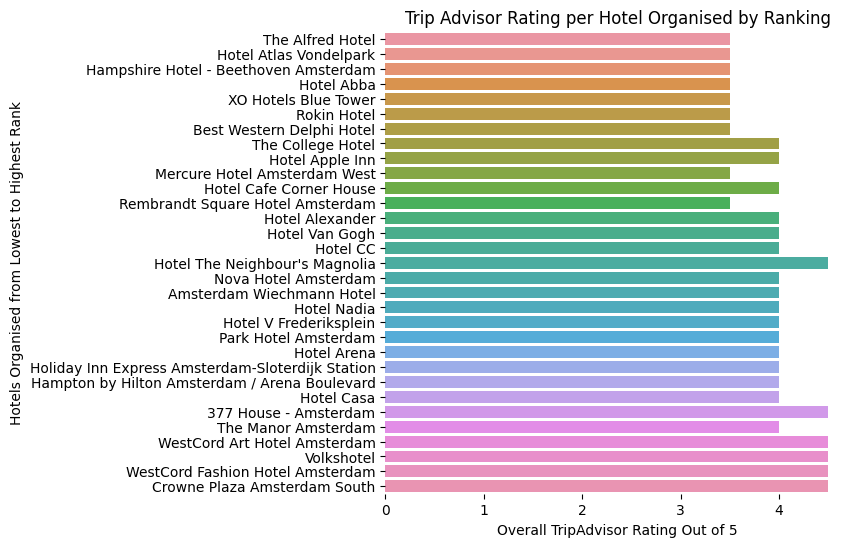

In [33]:
# Create an underlying plot to set the figure size.
f, ax = plt.subplots(figsize=(6, 6))
# Hotels are ordered in descending order from least to highest ranked on the TripAdvisor top rankings. 
# Putting the numeric variable in the x place orients the graph horizontally. 
sns.barplot(Analysis_Data.sort_values("ranking", ascending = False), x = "overall_rating", y = "name") 

# Removing the outlines on the left and bottom of the graph.
sns.despine(left = True, bottom = True)

ax.set(ylabel="Hotels Organised from Lowest to Highest Rank",
       xlabel = "Overall TripAdvisor Rating Out of 5")

plt.title("Trip Advisor Rating per Hotel Organised by Ranking")

plt.savefig("Rating_Per_Hotel_Ranked.png", bbox_inches = "tight")

plt.show()

While the above table shows the overall rating taken from TripAdvisor, the below more in depth table shows the average rating calculated from the dataset. This value is rounded to one decimal place and shown side by side with the overall rating for comparison. The minimum, maximum and standard deviation are also included. 

In [34]:
Hotel_Score = Analysis_Data.groupby("name").agg({"overall_rating" : "mean", "rating" : ["mean", "max", "min", "std"]}).round(decimals = 1)

Hotel_Score.to_csv("Hotel_Score.csv", encoding = "utf-8")

Hotel_Score

overall_rating rating      \
                                                           mean   mean max   
name                                                                         
377 House - Amsterdam                                       4.5    4.5   5   
Amsterdam Wiechmann Hotel                                   4.0    4.0   5   
Best Western Delphi Hotel                                   3.5    4.1   5   
Crowne Plaza Amsterdam South                                4.5    4.7   5   
Hampshire Hotel - Beethoven Amsterdam                       3.5    3.5   5   
Hampton by Hilton Amsterdam / Arena Boulevard               4.0    4.5   5   
Holiday Inn Express Amsterdam-Sloterdijk Station            4.0    4.0   5   
Hotel Abba                                                  3.5    3.9   5   
Hotel Alexander                                             4.0    3.9   5   
Hotel Apple Inn                                             4.0    3.7   5   
Hotel Arena                                                 4.0    3.8   5   
Hotel Atlas Vondelpark                                      3.5    3.6   5   
Hotel CC                                                    4.0    3.9   5   
Hotel Cafe Corner House                                     4.0    4.0   5   
Hotel Casa                                                  4.0    4.3   5   
Hotel Nadia                                                 4.0    4.1   5   
Hotel The Neighbour's Magnolia                              4.5    4.2   5   
Hotel V Frederiksplein                                      4.0    4.3   5   
Hotel Van Gogh                                              4.0    3.9   5   
Mercure Hotel Amsterdam West                                3.5    3.7   5   
Nova Hotel Amsterdam                                        4.0    3.8   5   
Park Hotel Amsterdam                                        4.0    4.3   5   
Rembrandt Square Hotel Amsterdam                            3.5    4.1   5   
Rokin Hotel                                                 3.5    4.2   5   
The Alfred Hotel                                            3.5    3.3   5   
The College Hotel                                           4.0    3.5   5   
The Manor Amsterdam                                         4.0    4.5   5   
Volkshotel                                                  4.5    4.3   5   
WestCord Art Hotel Amsterdam                                4.5    4.5   5   
WestCord Fashion Hotel Amsterdam                            4.5    4.3   5   
XO Hotels Blue Tower                                        3.5    3.7   5   

                                                           
                                                 min  std  
name                                                       
377 House - Amsterdam                              3  0.7  
Amsterdam Wiechmann Hotel                          2  0.9  
Best Western Delphi Hotel                          1  1.2  
Crowne Plaza Amsterdam South                       3  0.5  
Hampshire Hotel - Beethoven Amsterdam              1  1.1  
Hampton by Hilton Amsterdam / Arena Boulevard      2  0.9  
Holiday Inn Express Amsterdam-Sloterdijk Station   1  1.1  
Hotel Abba                                         1  1.1  
Hotel Alexander                                    1  0.9  
Hotel Apple Inn                                    1  1.0  
Hotel Arena                                        1  1.4  
Hotel Atlas Vondelpark                             1  1.3  
Hotel CC                                           2  0.7  
Hotel Cafe Corner House                            1  1.1  
Hotel Casa                                         1  1.1  
Hotel Nadia                                        1  1.1  
Hotel The Neighbour's Magnolia                     1  1.2  
Hotel V Frederiksplein                             1  0.9  
Hotel Van Gogh                                     1  0.9  
Mercure Hotel Amsterdam West                       1  1.3  
Nova Hotel Amste

**Number of Ratings Over Time**

Plotting the number of reviews per month shows that they all come from the period between November 2016 and March 2018 with the majority coming from the latter half of 2017 and the start of 2018. 

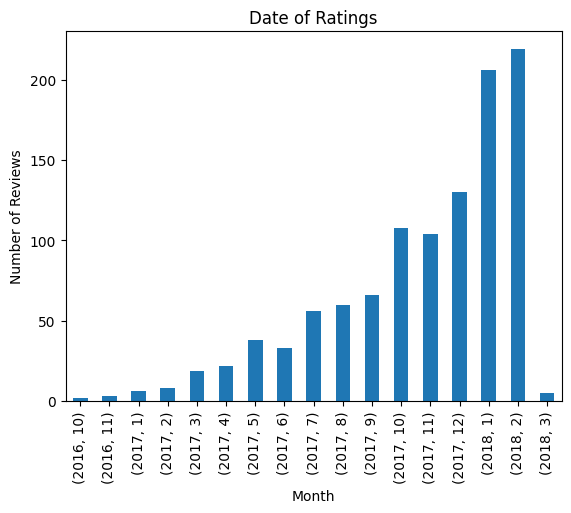

In [35]:
Rate_O_Time = Analysis_Data[["date"]]

# The data is grouped by the date and year elements of the 'date' datetime object. A bar chart is chosen which called on the 
# single column dataset returns a countplot without a legend. 
Rate_O_Time.groupby([Rate_O_Time['date'].dt.year, Rate_O_Time['date'].dt.month]).count().plot(kind="bar", legend = None) #*

plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.title("Date of Ratings")

plt.savefig("Date_of_Ratings.png", bbox_inches = "tight")

plt.show()

#* https://stackoverflow.com/questions/27365467/can-pandas-plot-a-histogram-of-dates

**Ratings Between Years**

This point chart shows the average ratings change from 2017 to 2018. Five hotels of different ranks are shown for illustration but this could be used to illustrate for the client their ratings change vs. their competitors between those two years or longer if more recent data was included. As the graph shows the XO Hotels Blue Tower saw an almost 1 point drop in ratingsfrom 2017 to 2018 whereas the Best Western Delphi saw an almost 1 point increase.

In [36]:
Ratings_Year = Analysis_Data[["date", "rating", "name"]]

# Pull out specifically the year information from the datetime object.
Ratings_Year["year"] = Ratings_Year["date"].dt.year

# Subset the data to show only specific hotels. 
Ratings_Year = Ratings_Year.loc[(Ratings_Year.name == "Best Western Delphi Hotel") | (Ratings_Year.name == "The Alfred Hotel") |
                                (Ratings_Year.name == "Hotel Nadia") | (Ratings_Year.name == "Crowne Plaza Amsterdam South") |
                                (Ratings_Year.name == "XO Hotels Blue Tower")]

C:\Users\Admin\AppData\Local\Temp\ipykernel_2264\3322116248.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Ratings_Year["year"] = Ratings_Year["date"].dt.year


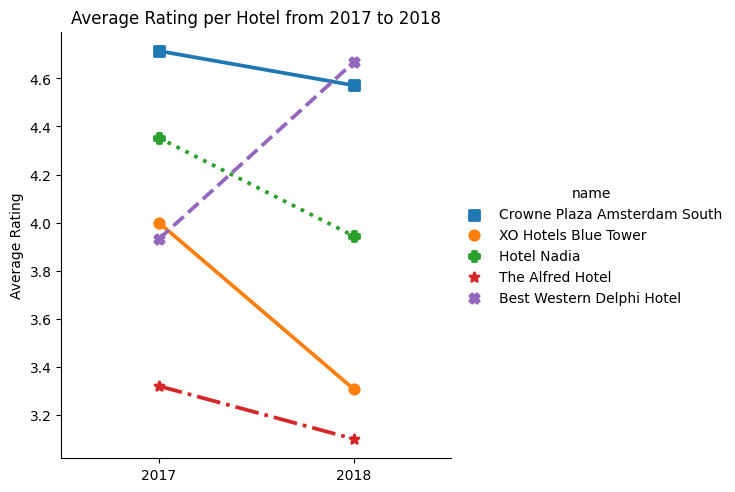

In [37]:
# Different linestyles and markers are selected to differentiate between hotels. 
sns.catplot(x="year", y="rating", hue = "name",
            linestyles=["solid", "solid", "dotted", "dashdot", "dashed"],
            markers = ["s", "o", "P", "*", "X"],
            kind="point", errorbar = None, data = Ratings_Year)

plt.title("Average Rating per Hotel from 2017 to 2018")
plt.ylabel("Average Rating")
plt.xlabel("") # Self explanatory axis labels are removed where possible. 

plt.savefig("Rating_Hotel_Year.png", bbox_inches = "tight")

plt.show()

The below table shows the change in average rating between 2017 and 2018 for all hotels. The max min and standard deviation are also displayed.

In [38]:
pd.set_option("display.max_rows", 100)

Ratings_Year_Tab = Analysis_Data[["date", "rating", "name"]]

Ratings_Year_Tab["year"] = Ratings_Year_Tab["date"].dt.year

Rating_Year_Tab = Ratings_Year_Tab.groupby(["name", "year"]).agg({"rating" : ["mean", "max", "min", "std"]}).round(decimals = 2)

Ratings_Year_Tab.to_csv("Ratings_Year_Tab.csv", encoding = "utf-8")

Rating_Year_Tab

C:\Users\Admin\AppData\Local\Temp\ipykernel_2264\1032707575.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Ratings_Year_Tab["year"] = Ratings_Year_Tab["date"].dt.year


rating              
                                                        mean max min   std
name                                             year                     
377 House - Amsterdam                            2017   4.50   5   3  0.69
                                                 2018   4.43   5   3  0.79
Amsterdam Wiechmann Hotel                        2017   3.97   5   2  0.91
                                                 2018   4.17   5   2  1.17
Best Western Delphi Hotel                        2017   3.93   5   1  1.25
                                                 2018   4.67   5   4  0.52
Crowne Plaza Amsterdam South                     2017   4.71   5   4  0.46
                                                 2018   4.57   5   3  0.65
Hampshire Hotel - Beethoven Amsterdam            2017   3.15   5   1  1.05
                                                 2018   4.33   5   4  0.50
Hampton by Hilton Amsterdam / Arena Boulevard    2017   5.00   5   5  0.00
                                                 2018   4.41   5   2  0.95
Holiday Inn Express Amsterdam-Sloterdijk Station 2017   4.09   5   1  1.38
                                                 2018   4.00   5   1  0.98
Hotel Abba                                       2017   3.77   5   1  1.14
                                                 2018   4.40   5   3  0.89
Hotel Alexander                                  2017   3.82   5   1  1.06
                                                 2018   4.00   4   4  0.00
Hotel Apple Inn                                  2017   3.46   5   1  1.02
                                                 2018   4.18   5   3  0.75
Hotel Arena                                      2017   4.00   5   1  1.25
                                                 2018   3.68   5   1  1.41
Hotel Atlas Vondelpark                           2016   4.00   5   3  0.71
                                                 2017   3.38   5   1  1.41
                                                 2018   4.17   5   3  0.98
Hotel CC                                         2017   3.81   5   2  0.68
                                                 2018   4.00   5   3  0.78
Hotel Cafe Corner House                          2017   4.06   5   1  1.13
                                                 2018   3.67   5   3  1.15
Hotel Casa                                       2017   4.06   5   1  1.30
                                                 2018   4.53   5   2  0.87
Hotel Nadia                                      2017   4.35   5   3  0.70
                                                 2018   3.94   5   1  1.30
Hotel The Neighbour's Magnolia                   2017   4.30   5   1  1.05
                                                 2018   3.00   5   1  2.83
Hotel V Frederiksplein                           2017   4.38   5   2  0.80
                                                 2018   4.07   5   1  1.00
Hotel Van Gogh                                   2017   3.86   5   1  1.01
                                                 2018   3.86   4   3  0.38
Mercure Hotel Amsterdam West                     2017   3.56   5   1  1.42
                                                 2018   3.90   5   1  1.10
Nova Hotel Amsterdam                             2017   3.64   5   1  1.11
                                                 2018   4.20   5   3  0.79
Park Hotel Amsterdam                             2017   3.86   5   1  1.46
                                                 2018   4.39   5   1  0.92
Rembrandt Square Hotel Amsterdam                 2017   4.00   5   2  1.06
                                                 2018   4.22   5   3  0.67
Rokin Hotel                                      2017   4.26   5   3  0.77
                                                 2018   3.50   5   2  1.29
The Alfred Hotel                                 2017   3.32   5   1  1.41
                                                 2018   3.10   5   1  1.45
The 

**Heatmap of Online vs. Offline Ratings**

Using a heatmap we can visualize how the ratings for each hotel differ between reviews made on the website or on mobile. As the graph shows certain hotels, Hotel Atlas Vondelpark for example have lower reviews on mobile than otherwise. 'Hampton by Hilton's' score on mobile is particularly large. This graph shows all hotels but a specific subset could be plugged in to give a potential client more granular analysis of how their hotel fairs on different media compared to their competitors. 

In [39]:
# Create a pivot table with mobile vs. non-mobile ratings per hotel. 
pivot_data = pd.pivot_table(Analysis_Data, values = "rating", index = ["name"], columns = "mobile").round(decimals = 2)

pivot_data.to_csv("Pivot_Data.csv", encoding = "utf-8")

pivot_data

mobile,Mobile,Online
name,,
377 House - Amsterdam,4.31,4.59
Amsterdam Wiechmann Hotel,4.36,3.76
Best Western Delphi Hotel,4.12,4.04
Crowne Plaza Amsterdam South,4.71,4.61
Hampshire Hotel - Beethoven Amsterdam,3.70,3.36
Hampton by Hilton Amsterdam / Arena Boulevard,4.90,4.28
Holiday Inn Express Amsterdam-Sloterdijk Station,3.95,4.15
Hotel Abba,3.62,4.05
Hotel Alexander,4.15,3.68


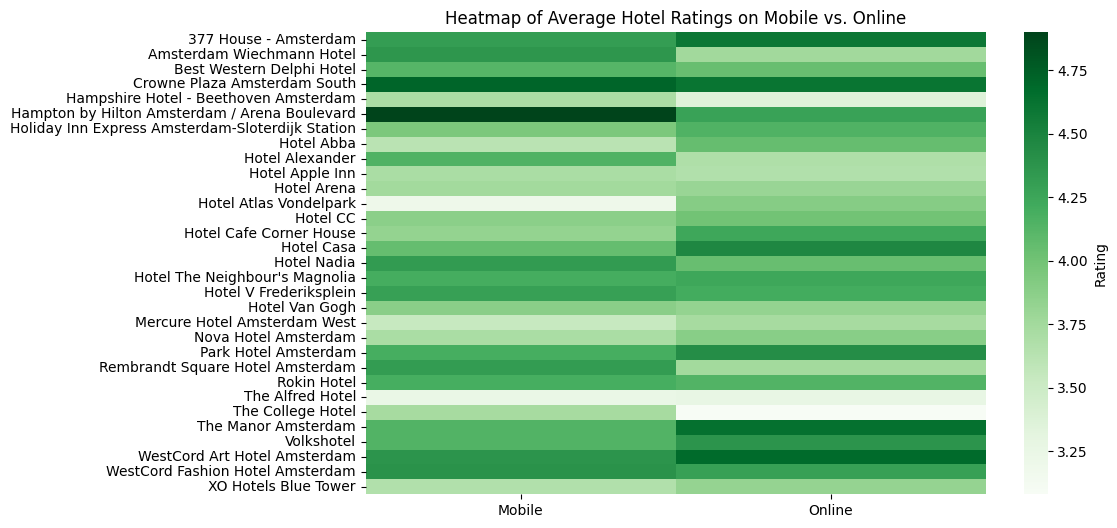

In [40]:
# Set the figure size in advance
plt.figure(figsize=(10, 6))
# The pivot data is used to creat a heatmap of the average rating per hotel from the reviews made on the website and on mobile. 
sns.heatmap(pivot_data, cmap="Greens", cbar_kws={"label": "Rating"})

plt.xlabel(None)
plt.ylabel(None)
plt.title("Heatmap of Average Hotel Ratings on Mobile vs. Online")

plt.savefig("Mobile_Heatmap.png", bbox_inches = "tight")

plt.show()

**Specific Ratings Per Hotel**

The below is a grouped bar graph showing the 'specific ratings' from the third level sub dictionary in the original data. This graph is then faceted for different hotels. The average of these ratings are shown for three hotels which are represented in three different faceted subplots. Again this is done for purposes of illustration but different hotels or a more extensive subset could also be included. As the graph shows, much the same as the overall ratings, most err on the higher side of the scale with not much variance in the different sub categories. This might point to a phenomenon whereby reviewers don't differentiate between different categories too much and tend to give similar scores across the board. 

In [41]:
# As only a smaller subset of the data has this information intact the decision was made to drop NAs rather than calculate them
# as calculating a mean for example would return many different hotels with the same scores and give an innacurate picture. 
Specific = Analysis_Data[["Location", "Cleanliness", "Service", "Sleep Quality", "Rooms", "Value", "name", "ranking"]].dropna()

In [42]:
# To use the variables in a grouped barplot the data is pivoted longer so that all specific ratings are the categories of one
# column. 
Specific = Specific.melt(id_vars = ["name", "ranking"], 
                   var_name = "rating_types", value_name = "rating_values")

#A subsection of hotels ar selected. 
Specific_Plot = Specific.loc[(Specific.name == "Hotel Nadia") | (Specific.name == "Hotel Casa") | 
                         (Specific.name == "The Manor Amsterdam")]

# The rating values are parsed to numeric. 
Specific_Plot["rating_values"] = pd.to_numeric(Specific_Plot["rating_values"])

C:\Users\Admin\AppData\Local\Temp\ipykernel_2264\427477614.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Specific_Plot["rating_values"] = pd.to_numeric(Specific_Plot["rating_values"])


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


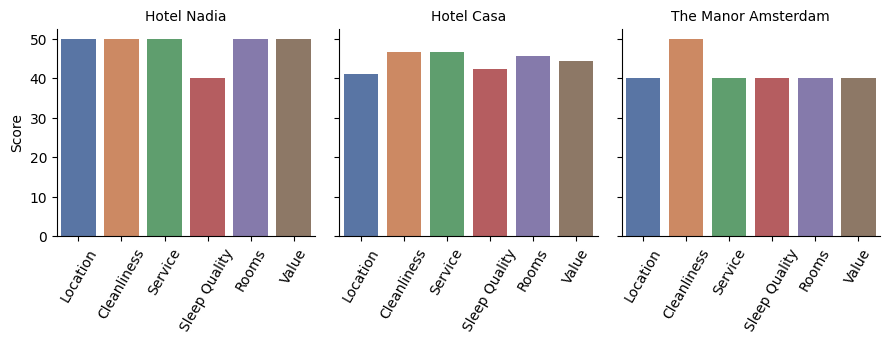

In [43]:
sns. color_palette() 
g = sns.FacetGrid(Specific_Plot, col = "name")
g.map(sns.barplot, 'rating_types', 'rating_values', errorbar = ("ci", False), palette = "deep")

g.set_titles("{col_name}") # This argument formats the titles to be cleaner. Without the subplot titles include "name = "   
g.set_axis_labels(x_var="", y_var="Score")
g.set_xticklabels(rotation = 60) # Rotate the x ticks for readability

plt.savefig("Rating_Hotel_Year.png", bbox_inches = "tight")

plt.show()

The below table shows the full ratings per every hotel with specific ratings. 

In [44]:
Specific["rating_values"] = pd.to_numeric(Specific["rating_values"])

Specific_Tab = Specific.groupby(["name", "rating_types"]).agg({"rating_values" : ["mean", "min", "max", "std"]}).round(decimals = 2)

Specific_Tab.to_csv("Specific_Tab.csv", encoding = "utf-8")

Specific_Tab

rating_values      \
                                                                     mean min   
name                                          rating_types                      
Best Western Delphi Hotel                     Cleanliness           36.67  20   
                                              Location              43.33  30   
                                              Rooms                 40.00  10   
                                              Service               43.33  20   
                                              Sleep Quality         43.33  30   
                                              Value                 35.00  20   
Hampshire Hotel - Beethoven Amsterdam         Cleanliness           45.00  40   
                                              Location              50.00  50   
                                              Rooms                 40.00  30   
                                              Service               50.00  50   
                                              Sleep Quality         45.00  40   
                                              Value                 45.00  40   
Hampton by Hilton Amsterdam / Arena Boulevard Cleanliness           47.27  30   
                                              Location              48.18  40   
                                              Rooms                 41.82  20   
                                              Service               46.36  30   
                                              Sleep Quality         40.00  10   
                                              Value                 43.64  20   
Hotel Casa                                    Cleanliness           46.67  30   
                                              Location              41.11  20   
                                              Rooms                 45.56  40   
                                              Service               46.67  30   
                                              Sleep Quality         42.22  10   
                                              Value                 44.44  20   
Hotel Nadia                                   Cleanliness           50.00  50   
                                              Location              50.00  50   
                                              Rooms                 50.00  50   
                                              Service               50.00  50   
                                              Sleep Quality         40.00  40   
                                              Value                 50.00  50   
Mercure Hotel Amsterdam West                  Cleanliness           47.14  40   
                                              Location              44.29  30   
                                              Rooms                 45.71  30   
                                              Service               47.14  40   
                                              Sleep Quality         45.71  30   
                                              Value                 48.57  40   
Park Hotel Amsterdam                          Cleanliness           50.00  50   
                                              Location              50.00  50   
                                              Rooms                 50.00  50   
                                              Service               30.00  30   
                                              Sleep Quality         50.00  50   
                                              Value                 50.00  50   
Rembrandt Square Hotel Amsterdam              Cleanliness           36.67  30   
                                              Location              43.33  40   
                                              Rooms                 36.67  30   
                                              Service               40.00  30   
                                              Sleep Quality         43.33  40   
          

**Average Number of Votes for Positive vs. Negative Reviews**

TripAdvisor have a function whereby reviews can be rated in terms of their helpfulness. This graph takes the average numver of votes for all reviews split for whether they are positive or negative (achieved by splitting the rating scale in half). As the graph illustrates positive reviews on average get more votes than negative reviews. 

In [45]:
votes = Analysis_Data[["rating_rec", "votes"]]

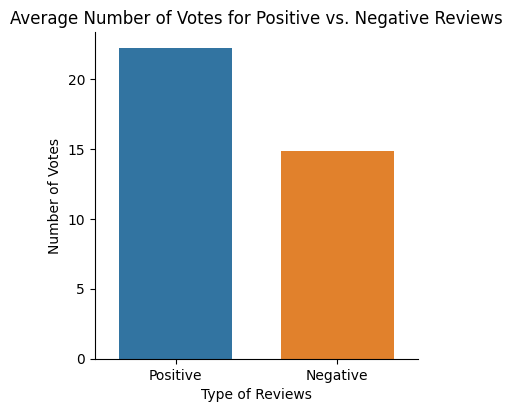

In [46]:
v = sns.catplot(data = votes, kind="bar",
    x="rating_rec", y="votes",
    errorbar= None, height=4, width = 0.7)

v.set_axis_labels("Type of Reviews", "Number of Votes")
plt.title("Average Number of Votes for Positive vs. Negative Reviews")

plt.savefig("Pos_Neg_Reviews.png", bbox_inches = "tight")

plt.show()

Due to outliers affecting the mean, the below table shows the mean and median votes per positive and negative reviews for comparison. 

In [47]:
PosNegMeanMed = votes.groupby("rating_rec").agg({"votes" : ["mean", "median", "max", "min", "std"]}).round(decimals = 2)

PosNegMeanMed.to_csv("PosNegMeanMed.csv", encoding = "utf-8")

PosNegMeanMed 

votes                          
             mean median    max  min    std
rating_rec                                 
Negative    14.86    5.0  131.0  1.0  26.12
Positive    22.24    8.5  792.0  1.0  52.78

**Votes by Review Length**

The following two scatterplots plot the length of reviews against the number of helpful votes they received. Four outliers, three in terms of vote numbers and one in terms of length, are not included in the second scatterplot merely to allow for a closer look at the data in the bottom left corner. As the graphs show the vast majority of reviews are less than 200 words long and have less than 50 votes. The most helpful reviews, those with the most votes, all for the most part less than 300 words in length. Not one review with more than 400 words has more than 50 'helpful' reviews. 

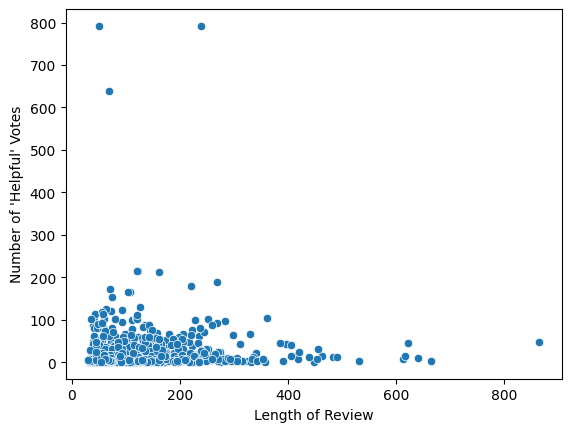

In [48]:
# NA values are dropped. 
RR_Len = Analysis_Data[["review_length", "votes"]].dropna()

sns.scatterplot(RR_Len, x = "review_length", y = "votes")

plt.ylabel("Number of 'Helpful' Votes")
plt.xlabel("Length of Review")

plt.savefig("Scatterplot_Wide.png", bbox_inches = "tight")

plt.show()

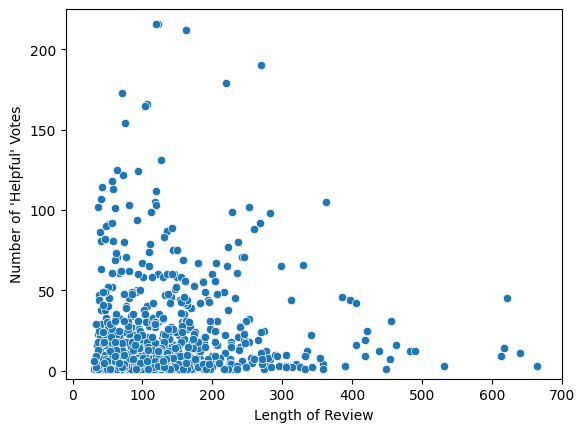

In [49]:
RR_Len = Analysis_Data[["review_length", "votes"]].dropna()


sns.scatterplot(RR_Len, x = "review_length", y = "votes")
plt.ylim(-5, 225)
plt.xlim(-10, 700) # The x and y axes are limited to get a closer look.

plt.ylabel("Number of 'Helpful' Votes")
plt.xlabel("Length of Review")

plt.savefig("Scatterplot_Narrow.png", bbox_inches = "tight")

plt.show()

**Types of Patron per Hotel**

The following graphs show the number of different types of patrons per hotel. The first graph show all hotels clearly illustrating that couples are the most frequent patrons of these hotels. A second graph is again included with a smaller subset of the data for a more specific comparison. Such a graph could be useful for the client to understand what clientel they attact compared to their competitiors. 

In [50]:
company = Analysis_Data[["travel_company", "name"]].dropna()

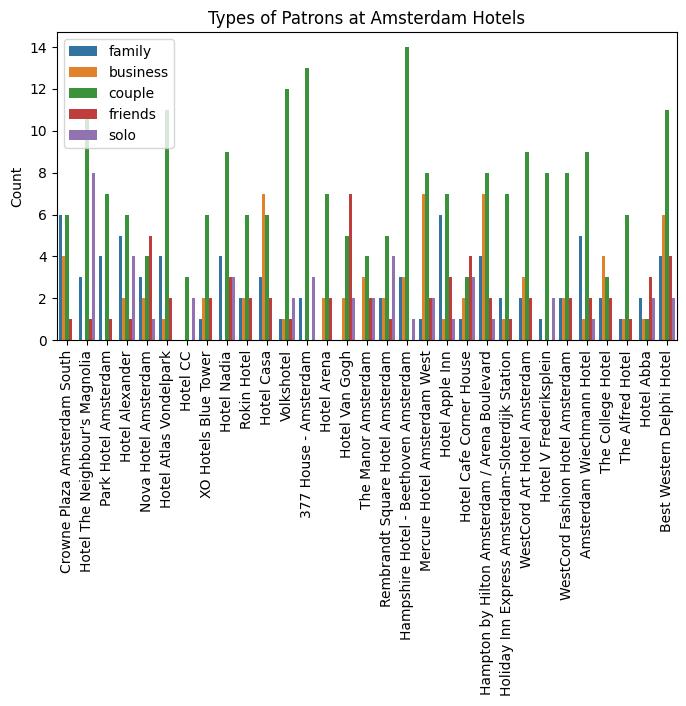

In [51]:
plt.figure(figsize=(8,4))
sns.countplot(company, x = "name", hue = "travel_company")

plt.ylabel("Count")
plt.xlabel("")
plt.legend(title = "Travel Partners")
plt.title("Types of Patrons at Amsterdam Hotels")
plt.xticks(rotation = 90)
plt.legend(loc='upper left')

plt.savefig("Patrons_Large.png", bbox_inches = "tight")

plt.show()

The below shows the exact number of clientel per hotel and clientel type.

In [52]:
pd.set_option("display.max_rows", 150)

company_tab = company.groupby(["name", "travel_company"]).agg({"travel_company" : "count"})

company_tab.to_csv("company_tab.csv", encoding = "utf-8")

company_tab

travel_company
name                                             travel_company                
377 House - Amsterdam                            couple                      13
                                                 family                       2
                                                 solo                         3
Amsterdam Wiechmann Hotel                        business                     1
                                                 couple                       9
                                                 family                       5
                                                 friends                      2
                                                 solo                         1
Best Western Delphi Hotel                        business                     6
                                                 couple                      11
                                                 family                       4
                                                 friends                      4
                                                 solo                         2
Crowne Plaza Amsterdam South                     business                     4
                                                 couple                       6
                                                 family                       6
                                                 friends                      1
Hampshire Hotel - Beethoven Amsterdam            business                     3
                                                 couple                      14
                                                 family                       3
                                                 solo                         1
Hampton by Hilton Amsterdam / Arena Boulevard    business                     7
                                                 couple                       8
                                                 family                       4
                                                 friends                      2
                                                 solo                         1
Holiday Inn Express Amsterdam-Sloterdijk Station business                     1
                                                 couple                       7
                                                 family                       2
                                                 friends                      1
Hotel Abba                                       business                     1
                                                 couple                       1
                                                 family                       2
                                                 friends                      3
                                                 solo                         2
Hotel Alexander                                  business                     2
                                                 couple                       6
                                                 family                       5
                                                 friends                      1
                                                 solo                         4
Hotel Apple Inn                                  business                     1
                                                 couple                       7
                                                 family                       6
                                                 friends                      3
                                                 solo                         1
Hotel Arena                                      business                     2
                                                 couple                       7
                                                 friends                      2
Hotel Atlas Vondelpark                           business        

In [53]:
company = company.loc[(company.name == "Hotel Cafe Corner House") | (company.name == "WestCord Art Hotel Amsterdam") |
                      (company.name == "Best Western Delphi Hotel")] # The company names of interest can be inserted here for a
                                                                     # more fine grain analysis. 

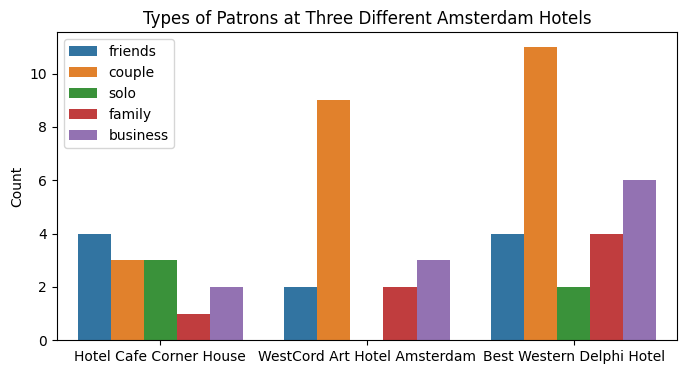

In [54]:
plt.figure(figsize=(8,4))
sns.countplot(company, x = "name", hue = "travel_company")

plt.ylabel("Count")
plt.xlabel("")
plt.legend(title = "Travel Partners")
plt.title("Types of Patrons at Three Different Amsterdam Hotels")
plt.legend(loc='upper left')

plt.savefig("Patrons_Small.png", bbox_inches = "tight")

plt.show()

**Response Time for Positive vs. Negative Reviews**

This last visualization shows the average response time for positive and negative reviews per hotel. Response time is measured in days as the difference between the response date and the date of the original review. There is a large variability in response time between hotels with one large outlier, Park Hotel Amsterdam, taking much longer to reply than the other hotels. 

*A Note on My Approach Here*

The response_date variable had values in different formats. While some were actual dates the way the info is represented on the website means that closer dates are represented as "x days ago" or "x weeks ago". In order not to lose this data a new variable needed to be computed. It was assumed that the "x days ago" was in relation to the time the data was scraped. Therefore the date_retrieved variable (formerly META.ADDED) could be used to parse this info as a specific date. The rows in response_date formulated as a date were recoded into a format amenable to being parsed and then using a for loop and the timedelta function data was appended to a list. If the row contained the word 'day', the number in the row was extracted as an int and taken away from the date in the 'date_retrieved' variable using the timedelta function. This date was then added to the list. Similarly if the row contained the word week the number was extracted and multiplied by seven before being taken away from the 'date_retrieved' date and added to the list. All 'none' values and actual dates were added to the list as is. This list was then changed into a data frame column and a new variable representing the difference (in days) between the "date" and the new "response_date" variable was computed for the visualization.  

In [55]:
Test = Analysis_Data[["response_date", "date_retrieved", "date", "rating_rec", "name"]]

In [56]:
# NAs are filled with a string "none" this decision was made as later when the response_date info is pulled into a list the 
# NAs were being dropped not allowing the list to be added back into the dataframe as a column. 
Test["response_date"] = Test["response_date"].fillna("none")

C:\Users\Admin\AppData\Local\Temp\ipykernel_2264\815482873.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Test["response_date"] = Test["response_date"].fillna("none")


In [57]:
# The commas are removed from the response_date variable.
Test["response_date"] = Test.response_date.str.replace(",", "")

C:\Users\Admin\AppData\Local\Temp\ipykernel_2264\2598767966.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Test["response_date"] = Test.response_date.str.replace(",", "")


In [58]:
# A number of dates with missing information are removed. These values are unfortunately hard coded. I had attempted to remove 
# them with a regex r"\^\d+\s\d+\&" but could not get this to work for some reason and in the end had to hardcode. Ideally these
# would be removed using the aforementioned regex.
recode_e = {"25 2017" : "none", "12 2017" : "none", "4 2017" : "none", "30 2017" : "none", "15 2017" : "none"}

In [59]:
Test["response_date"] = Test["response_date"].replace(recode_e)

C:\Users\Admin\AppData\Local\Temp\ipykernel_2264\3480217397.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Test["response_date"] = Test["response_date"].replace(recode_e)


In [60]:
dict1 = {"January" :"1", "February" : "2", "March" : "3", "April" : "4", "May" : "5", "June" : "6", "July" : "7", "August" : "8",
"September" : "9", "October" : "10", "November" : "11", "December" : "12"}

In [61]:
# The months in the "response_date" column are changed to numbers based on the information in the above dictionary. 
for k, v in dict1.items():
    Test.response_date = Test.response_date.str.replace(k, v)

C:\Users\Admin\AppData\Local\Temp\ipykernel_2264\3226101662.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Test.response_date = Test.response_date.str.replace(k, v)


In [62]:
# Date retrieved is formatted as a datetime. 
Test.date_retrieved = pd.to_datetime(Test.date_retrieved)

C:\Users\Admin\AppData\Local\Temp\ipykernel_2264\4207009478.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Test.date_retrieved = pd.to_datetime(Test.date_retrieved)


In [63]:
response_date_new = []

for row in Test.response_date:
    if "days ago" in row:
        daysago = re.match(r"\d", row).group(0) # find the number and subtract it from the retrieved date
        response_date_new.append(Test['date_retrieved'].iloc[0] - timedelta(days = int(daysago))) 
    elif "week ago" in row:
        weeksago = re.match(r"\d", row).group(0) # find the number multiply it by 7 and subtract it from the retrieved date
        response_date_new.append(Test['date_retrieved'].iloc[0] - timedelta(days = int(weeksago)*7))
    elif "weeks ago" in row:
        weeksago = re.match(r"\d", row).group(0) #*
        response_date_new.append(Test['date_retrieved'].iloc[0] - timedelta(days = int(weeksago)*7))
    elif "none" in row:
        response_date_new.append(np.nan)
    else:
        response_date_new.append(pd.to_datetime(row))
        
#* https://stackoverflow.com/questions/18493677/how-do-i-return-a-string-from-a-regex-match-in-python

In [64]:
Test["response_date_new"] = response_date_new

C:\Users\Admin\AppData\Local\Temp\ipykernel_2264\2876291283.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Test["response_date_new"] = response_date_new


In [65]:
Test["response_time"] = Test["response_date_new"] - Test["date"]

C:\Users\Admin\AppData\Local\Temp\ipykernel_2264\530683648.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Test["response_time"] = Test["response_date_new"] - Test["date"]


In [66]:
# Drop NAs, pull out the day information and parse as type int. 
Test["response_time"] = (Test["response_time"].dropna() / np.timedelta64(1, "D")).astype(int)

C:\Users\Admin\AppData\Local\Temp\ipykernel_2264\1091592720.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Test["response_time"] = (Test["response_time"].dropna() / np.timedelta64(1, "D")).astype(int)


In [67]:
# Remove hotels with no response time information. 
Test = Test.loc[(Test.name != "Hotel CC") & (Test.name != "Hotel Nadia") & (Test.name != "Rokin Hotel") & 
                (Test.name != "Hotel Van Gogh") & (Test.name != "Hotel Apple Inn") & (Test.name != "Hotel Cafe Corner House") &
                (Test.name != "The Alfred Hotel") & (Test.name != "Hampshire Hotel - Beethoven Amsterdam")]

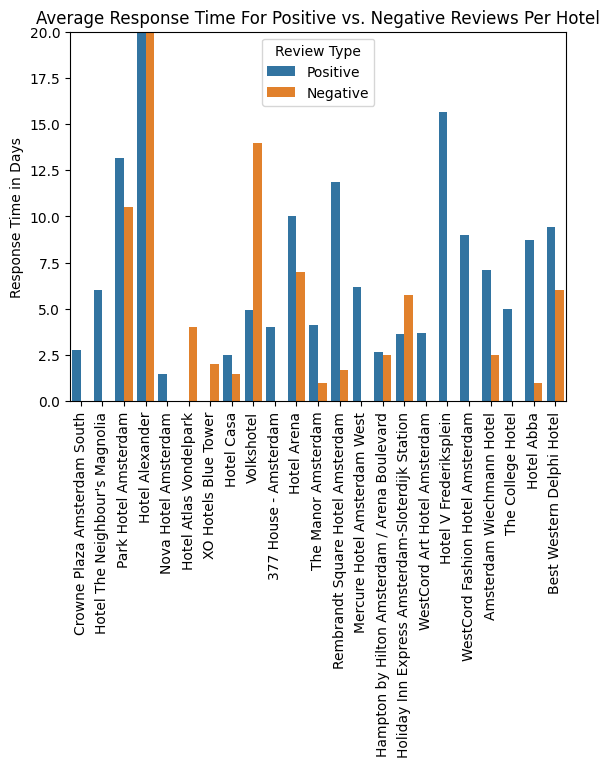

In [68]:
sns.barplot(data = Test, x = "name", y = "response_time", hue = "rating_rec", errorbar = None)
plt.xticks(rotation = 90)
plt.ylim(0, 20) # Limit the y axis for ease of seeing. This can be removed to see fully the outlier information. 
plt.title("Average Response Time For Positive vs. Negative Reviews Per Hotel")
plt.legend(title = "Review Type")
plt.ylabel("Response Time in Days")
plt.xlabel("")

plt.savefig("Response_Time.png", bbox_inches = "tight")

plt.show()